# Introduction

This notebook walks through a classifier to distinguish between emotions in the GoEmotions dataset introduced in [Demszky et al. 2020](https://aclanthology.org/2020.acl-main.372). In the present article, only six basic emotions in Ekman's theory, namely anger, disgust, fear, joy, sadness, and surprise, are considered. Other emotions are mapped to the basic ones by [the mapping](https://github.com/google-research/google-research/blob/master/goemotions/data/ekman_mapping.json) provided on the [paper's repository](https://github.com/google-research/google-research/tree/master/goemotions).


To quote the repository:
> GoEmotions is a corpus of 58k carefully curated comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral.

There are 82 annotators (or raters) in total, but each rater has rated only a subset of the corpus, so that for each text, ratings from at most 5 people are available.

It should be noted that the problem is a multi-label classification problem, because each comment could in principle belong to more than one emotion class. So the present article is in contrast with codes which make use of a single-label simplified version of the datase, like [this one](https://github.com/hazemhosny/Emotion-Sentiment-Analysis).

The other complicating factor is that the present classification task is a subjective classification task, as the same text can be (and is) assigned to different a label (or set of labels) by different annotators. So, to tackle the problem in its entirety, one cannot simply use voter-agreements to obtain a semi-objective classification dataset, something that has been done in the original paper, and followed  by others, e.g., [this blog post](https://towardsdatascience.com/multi-label-emotion-classification-with-pytorch-huggingfaces-transformers-and-w-b-for-tracking-a060d817923). As an aside, if it were the case, I would suggest using HuggingFace ```XXForSequenceClassification``` family of classes (e.g., ```BertForSequenceClassification```) with ```problem_type="multi_label_classification``` for the multi-lablel problem.

Instead, I take the problem as is. Emotion classification is a subjective task which means that a classifier not only depends on the input text, but also on the person who is performing the classification. So, the ```GoEmotionsClassifier``` model below takes two arguments:
* a text embedding, for which I opt for  [Sentence-BERT](https://www.sbert.net/) because it provides better sentence-level embeddings. The text embedding is then  projected into a seven-dimensional space (seven, because there are six basic emotions plus the neutral class)
* a rater ID -- the network projects the one-hot rater representation to a seven-dimensional space, which can be considered as the raters' embedding space. A TSNE of user embeddings is provided at the end.

The network adds above-mentioned vectors to make logits, which are transformed to probablities by element-wise sigmoid operations (as the problem is a multi-label classification). As expected, Binary Cross Entropy (```BCELoss```) is used as the loss function.

## Model performance
Performance metrics of the trained model is as follows (based on 3000 test data points):

For the first two metrics, "example based" definitions suggested in [this anwser](https://stats.stackexchange.com/a/234179/195389) are used.  The results are not comparable to the results in the original paper due to differences in the problem formulation.
* precision = 0.73
* recall = 0.70

## Ideas for improvement
Here are some ideas to improve the classifier:
* Obviously: more complex networks, more training time, etc.
* If rater metadata (age, gender, education, etc.) is available, train the "rater model"  in a multitask manner. Also, metadata can make the "rater model" more interpretable.
* Combine feature vectors from emotion vocabularies, like [NRC Emotion Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), with text and rater features.
* Assign a persona to the classifier, so that it makes personalized ratings.

# Prepration

In [ ]:
def remote_open(url, *args, **kwargs):
    import base64
    import urllib.request
    fn = url[url.rfind("/")+1:]  
    urllib.request.urlretrieve (url, fn)
    return open(fn, *args, **kwargs)

# from https://gist.github.com/KirillVladimirov/005ec7f762293d2321385580d3dbe335
def seed_everything(seed=42):
    import random, os, numpy, torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
from tqdm.notebook import tqdm

## Loading raw data

In [ ]:
raw_fns = ['https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_%d.csv' % i for i in range(1,4)]
raw_df = pd.concat([pd.read_csv(fn) for fn in raw_fns])
raw_df.reset_index(inplace=True, drop=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

In [ ]:
ekman_mapping = json.load(remote_open('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/ekman_mapping.json'))
ekman_mapping['neutral'] = ['neutral']
print(ekman_mapping) # dict for grouping all GoEmotions'es emotions into six Ekman emotions
ekman_emotions = list(ekman_mapping.keys())
print(ekman_emotions)

{'anger': ['anger', 'annoyance', 'disapproval'], 'disgust': ['disgust'], 'fear': ['fear', 'nervousness'], 'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude', 'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'], 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'], 'surprise': ['surprise', 'realization', 'confusion', 'curiosity'], 'neutral': ['neutral']}
['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']


## Making a refined DataFrame

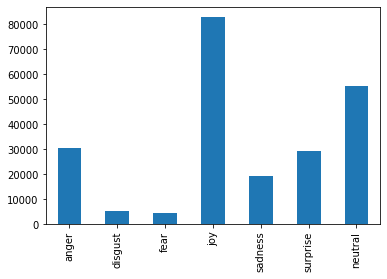

Number of rows that are assigned more than one emotions = 18024
Number of rows that are assigned no emotion = 3411
Number of rows = 207814
Nmber of texts = 58009
Nmber of raters = 82


In [ ]:
# Grouping all GoEmotions'es emotions into six Ekman emotions
all_emotions = [] # all GoEmotions (except 'neutral')
ekman_df = raw_df.copy() # a new DataFrame to keep the grouped emotions as a binary values
for ekman_type, emotion_list in ekman_mapping.items():
    all_emotions.extend(emotion_list)
    ekman_df[ekman_type] = ekman_df[emotion_list].any(axis=1).astype(int)
    
ekman_df.drop(set(all_emotions)-set(ekman_emotions), axis=1, inplace=True)
ekman_df.reset_index(inplace=True, drop=True)
ekman_df[ekman_emotions].sum(axis=0).plot(kind='bar')
plt.show()

print('Number of rows that are assigned more than one emotions = %d'% len(ekman_df[ekman_df[ekman_emotions].sum(axis=1)>1]))

print('Number of rows that are assigned no emotion = %d'% len(ekman_df[ekman_df[ekman_emotions].sum(axis=1)==0]))
assert len(ekman_df[ekman_df[ekman_emotions].sum(axis=1)==0]) == len(raw_df[raw_df['example_very_unclear'] == 1])
# Removing rows that are assigned no emotion
ekman_df.drop(ekman_df[ekman_df[ekman_emotions].sum(axis=1)==0].index, inplace=True)

print('Number of rows = %d' % len(ekman_df))
print('Nmber of texts = %d' % len(ekman_df.groupby('id')))

num_raters = len(ekman_df.groupby('rater_id'))
print('Nmber of raters = %d' % num_raters)

## Making refined train/test datasets
As [the train/test split distributed by GoEmotions](https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt) is based on rater agreement (also, it uses all emotions -- not neccessarily Ekman's), we build our own split.

For now, we use random shuffling with no data stratification. A better way, would be to use iterative stratification (as we are using multilable data), e.g., as implemented in [scikit-multilearn's implementaion](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html); see also [here](http://scikit.ml/stratification.html)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ekman_df, test_size=0.2, random_state=42)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

# Model definition

In [ ]:
#!pip install transformers
!pip install sentence-transformers

In [ ]:
import torch
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on %s (index=%s)' % (device.type, str(device.index)))

Running on cpu (index=None)


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
text_emb_size = int(len(sbert_model.encode('')))
print('SentenceBert embeding size = %d' % text_emb_size)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
class GoEmotionsClassifier(nn.Module):
    def __init__(self, text_emb_size, num_raters, output_size):
          super(GoEmotionsClassifier, self).__init__()
          self.lm_to_ekman_layer = nn.Linear(text_emb_size, output_size)
          self.rater_embedding_layer = nn.Linear(num_raters, output_size)
          # self.tfid_layer = nn.Linear(output_size, output_size, max_norm=True)
          self.num_raters = num_raters
          self.rater_onehots = np.eye(num_raters)
          
    def forward(self, text_emb, rater_id):
          lm_to_ekman = self.lm_to_ekman_layer(text_emb)
          #print('text_emb', len(text_emb), text_emb[0].numel())
          #print('lm_to_ekman', len(lm_to_ekman), text_emb[0].numel())

          rater_tensor = torch.Tensor(self.rater_onehots[rater_id])
          #print('rater_tensor', rater_tensor)
          rater_emb = self.rater_embedding_layer(rater_tensor)
          #print('rater_emb', rater_emb)
          
          output = lm_to_ekman + rater_emb
          final_output = torch.sigmoid(output)         
          return final_output

model = GoEmotionsClassifier(text_emb_size, num_raters, len(ekman_emotions))

from os import path
if path.exists('model.pt'):
    model.load_state_dict(torch.load('model.pt'))

In [14]:
# pick an example
EX_ROW_NUM = 0
a_text = train_df['text'].iloc[EX_ROW_NUM]
a_emb = sbert_model.encode(a_text)
a_rater_id = int(train_df['rater_id'].iloc[EX_ROW_NUM])
print(a_text, a_rater_id, a_emb.shape)

with torch.no_grad():
    a = model(torch.Tensor(a_emb), a_rater_id)
    #print([int(.5<e) for e in a])

    # simulating a batch operation
    b = model(torch.Tensor([a_emb, a_emb]), [a_rater_id, a_rater_id])
    #print(len(b.shape))
    #print(b)
    #print([[int(.5<e) for e in ab] for ab in b])

I'm sorry for what happened to you. I guess you were sending mixed signals all the time. 52 (384,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  del sys.path[0]


# Training the model

In [16]:
# training parameters
BATCH_SIZE = 4
NUM_EPOCHS = 2

## Defining a training and test Datasets

In [17]:
from torch.utils.data import Dataset, DataLoader

class GoEmotionsClassifierDataset(Dataset):
    def __init__(self, df, text_embedder, ekman_emotions):
        super(GoEmotionsClassifierDataset).__init__()
        self.df = df
        self.text_embedder = text_embedder
        self.ekman_emotions = ekman_emotions
        
    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, i):
        text = self.df.loc[i, 'text']
        text_emb = self.text_embedder.encode(text)
        rater_id = self.df.loc[i, 'rater_id']
        labels = self.df.loc[i, self.ekman_emotions].to_list()
        #print('dataset::labels', labels, len(labels))
        return text_emb, rater_id, labels

training_loader = DataLoader(
      GoEmotionsClassifierDataset(train_df, sbert_model, ekman_emotions), batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

## The trainign loop

In [18]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from os import path
if path.exists('model.pt'):
    raise Exception('Please uncomment this line if you really want to retrain the model.')

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(training_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        text_emb, rater_id, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(text_emb, rater_id)
        #print('outputs', outputs)
        #print('labels', labels, len(labels))
        labels = torch.Tensor([t.tolist() for t in labels])
        labels = torch.transpose(labels, 0, 1)
        #print('labels', labels)
        loss = criterion(outputs, torch.Tensor(labels))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# save the model
torch.save(model.state_dict(), './model.pt')

Exception: ignored

# Testing the model

In [51]:
test_loader = DataLoader(
      GoEmotionsClassifierDataset(test_df[0:3000], sbert_model, ekman_emotions), batch_size=1, shuffle=True, num_workers=1)

In [59]:
model.eval()

# Using the example based defintions described here:
#https://stats.stackexchange.com/questions/21551/how-to-compute-precision-recall-for-multiclass-multilabel-classification
precisions, recalls = [], []



with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader, 0)):
        text_emb, rater_id, labels = data

        labels = torch.Tensor([t.tolist() for t in labels])
        labels = torch.transpose(labels, 0, 1)[0].long().numpy()
        
        an_output = model(text_emb, rater_id)[0]
        # it was better to create a predict function is GoEmotionsClassifier, but it requires retraining the model :-(
            
        pred = np.array([int(.5<e) for e in an_output])
        #print(pred.dtype, labels.dtype)
        precisions.append((labels & pred).sum()/pred.sum())
        recalls.append((labels & pred).sum()/labels.sum())        

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


In [65]:
precisions = np.array(precisions)
precisions_new = precisions[~np.isnan(precisions)]

recalls = np.array(recalls)
recalls_new = recalls[~np.isnan(precisions)]

print('precision = %f' % precisions_new.mean())
print('recall = %f' % recalls_new.mean())

precision = 0.737722
recall = 0.707550


# Visualization of rater embeddings


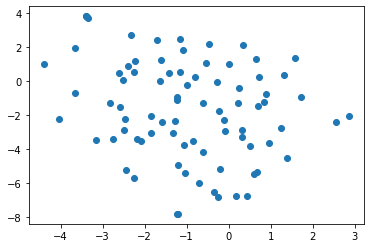

In [22]:
import numpy as np
from sklearn.manifold import TSNE

with torch.no_grad():
    rater_tensor = torch.Tensor(model.rater_onehots[range(num_raters)])
    #print('rater_tensor', rater_tensor)
    rater_emb = model.rater_embedding_layer(rater_tensor)
    rater_emb.tolist()
    rater_emb_tsne = TSNE(n_components=2, learning_rate='auto',
                      init='random').fit_transform(rater_emb)

ax = plt.scatter(rater_emb_tsne[:,0], rater_emb_tsne[:,1])